In [1]:
using BenchmarkTools, SpecialFunctions
using LinearAlgebra, Statistics
using Parameters
using Plots
using Optim #https://github.com/JuliaNLSolvers/Optim.jl
using Random, Distributions
gr(fmt=:png); # setting for easier display in jupyter notebooks
using TypedTables
using ThreadsX, Folds # these are multithreading tools
using QuantEcon
using SparseArrays
using BasisMatrices

In [2]:
model_params = @with_kw (
    β= 0.96,
    R = 1.0292,
    γ = 3.0,
    amin = -3.0,
    amax = 16.0,
    Na=100,
    agrid = range(amin,amax,length=Na),
    Nshocks = 7,
    ρ = 0.20,
    σ = 0.3919,
    mc= rouwenhorst(Nshocks, ρ, σ),
    Niter = 500,
    )

##NamedTuple_kw#257 (generic function with 2 methods)

In [28]:
function consumption(R, a, ap, w)
    
        c = R*a .- ap .+ w
    
    return c
    
end

##########################################################################
##########################################################################

function utility(c, γ)
    
    if abs(γ - 1.0) < 1e-10
        
        (c < 1e-5 ? -1e10 : log(c)) 

    else
        (c < 1e-5 ? -1e10 : c^( 1.0 - γ) / (1.0 - γ)) 
    end

end

##########################################################################
##########################################################################

function make_utility(model_params)
    
    @unpack Na, Nshocks, γ, R, mc, agrid = model_params
    
    utility_grid = Array{Float64}(undef, Na, Na, Nshocks)
    
    a =  reshape(agrid, Na, 1)
    
    a_prime = reshape(agrid, 1, Na)
    
    for xxx = 1:Nshocks
        
        c = consumption(R, a, a_prime, exp.(mc.state_values[xxx]))
        
        utility_grid[:, :, xxx] = utility.(c, γ)
    
    end
    
    return utility_grid
    
end

##########################################################################
##########################################################################

function compute_EV(v::Array{T}, mc_probs::Vector{T}) where T
     
    # so mc_probs should be a 1 by Nshock row vector 
    # then v should be Nassset state, Nshock state matrix
    # we want to integrate this so transpose, so for a given
    # asset state integrate accross different shock outcomes
    
    return  (mc_probs' * v' )

end

##########################################################################
##########################################################################

function value_function_itteration(model_params ; tol = 10^-3)
    
    @unpack Na, Nshocks, Niter, β, mc = model_params
    
    u = make_utility(model_params)

    Tv = zeros(eltype(u), Na, Nshocks)
    
    v = similar(Tv)

    for iter = 1:Niter

        for xxx = 1:Nshocks
                    
            βEV = compute_EV(β*Tv, mc.p[xxx,:])
            
            maximum!(view(Tv,:,xxx), u[:, :, xxx] .+ βEV)
            #this is fastest and writes on TV directly
            # lower number of allocations too
            # the view command is what allows the direct writing on 
            # a slice of the array, without it, nodice

        end
    
        test_tol = norm(Tv - v)
        
        if test_tol < tol
            
            #println("value function converged")
            #println(iter)
            #println(test_tol)
                        
            break
        end
        
        v = copy(Tv)

    end
    
    aindx = Array{CartesianIndex{2}}(undef, size(Tv))
            
    for xxx = 1:Nshocks
                    
        βEV = compute_EV(β*Tv, mc.p[xxx,:])
        
        Tv[:, xxx], aindx[:, xxx] = findmax(u[:, :, xxx] .+ βEV , dims = 2)
        # now get the policies

    end
    
    return Tv, aindx
end


##########################################################################
##########################################################################


function make_transition_prob(model_params, asset_indx::Matrix{CartesianIndex{2}})
      
    @unpack Na, Nshocks, mc = model_params

    statesize = convert(Int64, Na*Nshocks)
    
    transition_prob = Array{Float64}(undef, statesize, statesize)

    for ast = 1:Na
        
        ast_counter = convert(Int64, (ast - 1)*Nshocks)
            
        for shk = 1:Nshocks
            
            foo = zeros(1, Na)
    
            foo[asset_indx[ast, shk][2]] = 1.0
    
            transition_prob[shk + ast_counter, :] = BasisMatrices.row_kron(foo, mc.p[shk,:]' )
            # this part on the row still confuses me a bit...need to explain better.
            
            #println(shk + ast_counter)
            
        end
        
    end
    
    return transition_prob
    
end

##########################################################################
##########################################################################

function stationary_dist(Q::Array{Float64, 2})
    # this is faster than the quant econ canned routine
    # from lyon-waugh implementation
    
    L = zeros(size(Q, 1))
    
    L[1] = 1.0
    
    max_it = 5000
    
    Lnew = similar(L)
    
    for xxx = 1:max_it
        
        Lnew = transpose(Q) * L
        #this ordering is also better in julia
        # than my matlab implementation of Q*L (1, na*nshock)
                
        err = maximum(abs, L - Lnew)
        
        copy!(L, Lnew)
        # this surprisingly makes a big difference
        # but in the vfi it causes a lot of problems?
        
        err < 1e-10 && break
        
    end
    
    return L
end

stationary_dist (generic function with 1 method)

In [376]:
?Transpose

search: Transpose transpose transpose! copy_transpose! TransparentColor



```
Transpose
```

Lazy wrapper type for a transpose view of the underlying linear algebra object, usually an `AbstractVector`/`AbstractMatrix`, but also some `Factorization`, for instance. Usually, the `Transpose` constructor should not be called directly, use [`transpose`](@ref) instead. To materialize the view use [`copy`](@ref).

This type is intended for linear algebra usage - for general data manipulation see [`permutedims`](@ref Base.permutedims).

# Examples

```jldoctest
julia> A = [3+2im 9+2im; 8+7im  4+6im]
2×2 Matrix{Complex{Int64}}:
 3+2im  9+2im
 8+7im  4+6im

julia> transpose(A)
2×2 transpose(::Matrix{Complex{Int64}}) with eltype Complex{Int64}:
 3+2im  8+7im
 9+2im  4+6im
```


In [33]:
@btime value_function_itteration(test ; tol = 10^-3);

  97.741 ms (29571 allocations: 255.13 MiB)


In [396]:
@btime vfi2(test ; tol = 10^-3);

  74.549 ms (14271 allocations: 253.57 MiB)


In [32]:
@btime vfi2(test ; tol = 10^-3);

  90.356 ms (14271 allocations: 253.57 MiB)


In [424]:
@btime stationary_dist(tprob);

  59.318 ms (1094 allocations: 8.48 MiB)


In [414]:
@btime stationary_dist(tprob);

  59.537 ms (1094 allocations: 8.48 MiB)


In [29]:
@btime stationary_dist(tprob);

  1.525 ms (32 allocations: 254.00 KiB)


  0.125913 seconds (14.27 k allocations: 253.569 MiB, 16.93% gc time)
vfi done
  0.010687 seconds (3.00 k allocations: 16.388 MiB)
  0.100972 seconds (1.09 k allocations: 8.480 MiB)


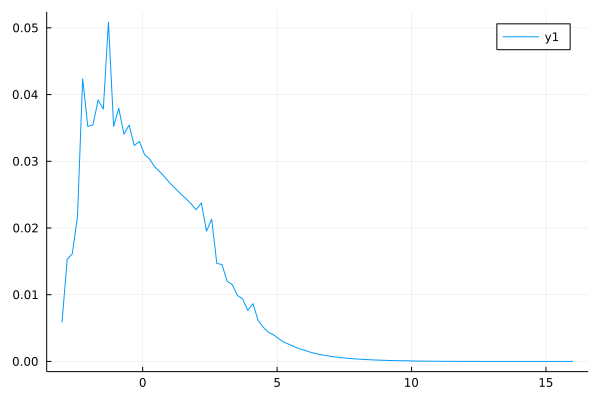

In [31]:
test = model_params(σ = 0.3919, Nshocks = 10, Na = 100, amin = -3.0, amax = 16)

@time vfout, pout = vfi2(test ; tol = 10^-3);

println("vfi done")

@time tprob = make_transition_prob(test, pout);

@time  st = stationary_dist(tprob);

st = reshape(st,test.Nshocks,test.Na)'

plot(test.agrid, sum(st, dims = 2))

  0.105520 seconds (14.27 k allocations: 253.569 MiB, 16.52% gc time)
vfi done
  0.014850 seconds (3.00 k allocations: 16.388 MiB)
transmat done
  0.316874 seconds (11.01 k allocations: 20.565 MiB)
stationary done


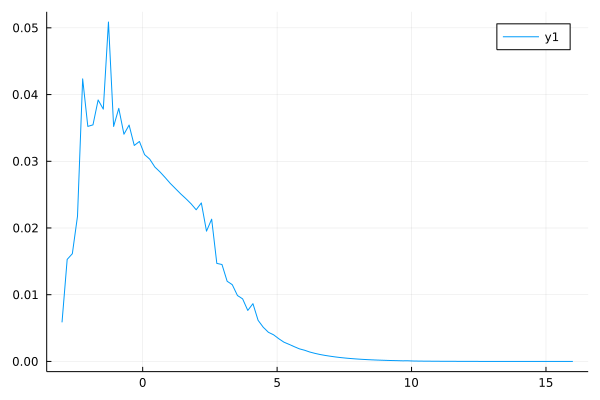

In [409]:
test = model_params(σ = 0.3919, Nshocks = 10, Na = 100, amin = -3.0, amax = 16)

@time vfout, pout = vfi2(test ; tol = 10^-3);

println("vfi done")

@time tprob = make_transition_prob(test, pout);

println("transmat done")

@time st  = stationary_distributions(MarkovChain(tprob))[1]
# this part is very slow...

println("stationary done")

st = reshape(st,test.Nshocks,test.Na)'

plot(test.agrid, sum(st, dims = 2))

In [191]:
?maximum!

search: maximum! maximum



```
maximum!(r, A)
```

Compute the maximum value of `A` over the singleton dimensions of `r`, and write results to `r`.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> maximum!([1; 1], A)
2-element Vector{Int64}:
 2
 4

julia> maximum!([1 1], A)
1×2 Matrix{Int64}:
 3  4
```


In [198]:
A = [1 2; 3 4]

2×2 Matrix{Int64}:
 1  2
 3  4

In [207]:
r = [3; 4]

maximum!(r, A)

2-element Vector{Int64}:
 2
 4

In [208]:
r

2-element Vector{Int64}:
 2
 4

In [214]:
test = model_params(σ = 0.3919, Nshocks = 3, Na = 5, amin = 0, amax = 2)

u = make_utility(test)

5×5×3 Array{Float64, 3}:
[:, :, 1] =
 -1.54987    -108.177      -1.0e10     -1.0e10    -1.0e10
 -0.426624     -1.47316   -73.3094     -1.0e10    -1.0e10
 -0.196001     -0.415346   -1.40201   -52.9377    -1.0e10
 -0.112117     -0.192467   -0.404509   -1.33589  -40.0126
 -0.0724858    -0.110582   -0.189027   -0.39409   -1.27434

[:, :, 2] =
 -0.5        -2.0        -1.0e10       -1.0e10      -1.0e10
 -0.217959   -0.485714   -1.88812   -2345.66        -1.0e10
 -0.121428   -0.213817   -0.472031     -1.78538   -586.414
 -0.0772688  -0.1197     -0.209792     -0.458918    -1.6908
 -0.0534542  -0.0763894  -0.118008     -0.205879    -0.446345

[:, :, 3] =
 -0.161304   -0.314637   -0.864269   -7.36201    -1.0e10
 -0.0965891  -0.158662   -0.307474   -0.832021   -6.6016
 -0.0642424  -0.0953613  -0.156084   -0.300552   -0.801544
 -0.0457913  -0.0635752  -0.0941567  -0.153568   -0.293862
 -0.0342822  -0.0453893  -0.0629184  -0.0929749  -0.151113

In [327]:
r = rand(5,3)

Folds.maximum(u[:,:,3], dims = 2)

LoadError: MethodError: no method matching transduce_assoc(::Transducers.IdentityTransducer, ::Transducers.Completing{typeof(max)}, ::Transducers.InitOf{Folds.Implementations.FoldsInitOf}, ::Transducers.Eduction{Transducers.Reduction{Transducers.Map{typeof(identity)}, Transducers.BottomRF{Transducers.Completing{typeof(BangBang.push!!)}}}, Matrix{Float64}}; dims=2, simd=Val{true}())
[0mClosest candidates are:
[0m  transduce_assoc(::Transducers.Transducer, ::F, ::Any, ::Any; simd, basesize, stoppable, nestlevel) where F at C:\Users\mwaugh\.julia\packages\Transducers\4zaoS\src\reduce.jl:104[91m got unsupported keyword argument "dims"[39m

In [280]:
view(r,:,3)

5-element view(::Matrix{Float64}, :, 3) with eltype Float64:
 0.097318930733294
 0.8658557594654419
 0.5765459729005302
 0.3489377150619797
 0.3890127491888071

In [283]:
r

5×3 Matrix{Float64}:
 0.0135991  0.751847   -0.161304
 0.0846448  0.0967765  -0.0965891
 0.510862   0.999665   -0.0642424
 0.185699   0.74594    -0.0457913
 0.141676   0.0237141  -0.0342822